# BLEU : Bilingual Evaluation Understudy

BLEU, which stands for Bilingual Evaluation Understudy, is an metric that was introduced to quantitatively evaluate the quality of machine translations. The motivation is clear: as humans, we are able to get an intuitive sense of whether or not a given translation is accurate and of high quality; however, it is difficult to translate this arbitrary linguistic intuition to train NLP models to produce better translations. This is where BLEU comes to the rescue.

The way BLEU works is simple. Given some candidate translation of a sentence and a group of reference sentences, we use a bag-of-word approach to see how many occurences of BOWs co-occur in both the translation and reference sentences. BOW is a simple yet highly effective way of ensuring that the machine translation contains key phrases or words that reference translations also contain. In other words, BLEU compares candidate translations with human-produced, annotated reference translations and compares how many hits there are in the candidate sentence. The more BOW hits there are, the better the translation.

Of course, there are many more details that go beyond this. For instance, BLEU is able to account for situations in which meaningless words are repeated throughout the machine translation to simply increase BOW hits. It can also penalize translations that are too short. By combining this BOW precision-based approach with some penalization terms, BLEU provides a robust means of evaluating machine translations. 

# N-Grams Implementation

convert_to_grams function converts a given sentence into list of n-grams with the provided "n" as input

In [3]:
lower_n_split_values = lambda x: x.lower().split()
def Convert_to_ngrams(sentence, n):
    words = lower_n_split_values(sentence)
    ngrams = []
    for i in range(len(words) - n + 1):
        ngrams.append(" ".join(words[i : i + n]))
    return ngrams

# N-Grams Sanity Check

In [4]:
Convert_to_ngrams("This is a sample test sentence",2)

['this is', 'is a', 'a sample', 'sample test', 'test sentence']

Before understanding we need to understand few conceepts which help us in unnderstanding BLEU metric

### Precision

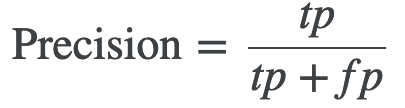

* where tp and fp stand for true and false positives, respectively.
* we can consider positives as roughly corresponding to the notion of hits or matches. 
* In other words, the positives are the bag of word n-grams we can construct from a given candidate translation. 
* True positives are n-grams that appear in both the candidate and some reference translation.
* false positives are those that only appear in the candidate translation.

# Simple Precision Implementation

In [5]:
def simple_precision_implementation(ca, refs, n):
    ngrams = Convert_to_ngrams(ca, n)
    count = 0
    for ngram in ngrams:
        for ref in refs:
            if ngram in Convert_to_ngrams(ref, n):
                count += 1
                break
    return count / len(ngrams)


# Simple Precision Sanity Check

In [6]:
candidate_1 = "It is a guide to action which ensures that the military always obeys the commands of the party"
candidate_2 = "It is to insure the troops forever hearing the activity guidebook that party direct"
references = [
    "It is a guide to action that ensures that the military will forever heed Party commands",
    "It is the guiding principle which guarantees the military forces always being under the command of the Party",
    "It is the practical guide for the army always to heed the directions of the party"
]

print(simple_precision_implementation(candidate_1, references, 1))
print(simple_precision_implementation(candidate_2, references, 1))


0.9444444444444444
0.5714285714285714


# Modified Precision

Simple precision based metric have huge problems like if we have a sample andidate as "It it it it it it it it it it it it it" the simple precision gives 1 as output but given candidate is very bad.

This is because precision simply involves checking whether a hit occurs or not: it does not check for repeated bag of words.hence modified precision is implemented and in modified precision we will clip the n-gram count if those are repeated multiple times.and formula is as follows
 
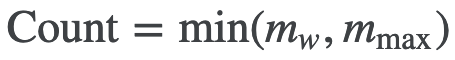
 
* Count refers to the number of hits we assign to a certain n-gram.
* m_w refers to the number of occurrences of a n-gram in the candidate sentence.
* m_max, which is the maximum number of occurrence of that n-gram in any one of the reference sentences. 

# Modified Precision Implementation

In [7]:
from collections import Counter

def modified_precision_implementation(ca, refs, n):
    ngrams = Convert_to_ngrams(ca, n)
    ngram_counts = Counter(ngrams)
    total_count = 0
    for ngram in set(ngrams):
        maximum_count = 0
        for ref in refs:
            maximum_count = max(maximum_count, Counter(Convert_to_ngrams(ref, n)).get(ngram, 0))
        total_count += min(maximum_count, ngram_counts[ngram])
    return total_count / len(ngrams)


# Modified Precision Implementation Sanity Check

In [8]:
bad_candidate = "Commands Commands Commands Commands Commands Commands Commands "
print(simple_precision_implementation(bad_candidate, references, 1))
print(modified_precision_implementation(bad_candidate, references, 1))

1.0
0.14285714285714285


# Brevity Penality

Brevity penality penalises short candiadate translations thus ensuring that only sufficiently long machine translations are ascribed a high score.The goal is to find the length of the reference sentence whose length is closest to that of the candidate translation in question. If the length of that reference sentence is larger than the candidate sentence, we apply some penalty; if the candidate sentence is longer, than we do not apply any penalization. The specific formula for penalization looks as follows:

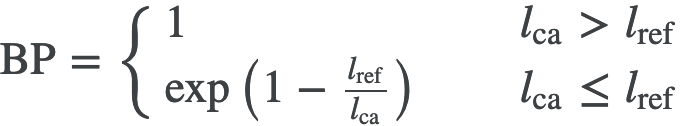

# Brevity Penality Inplementation

In [9]:
import numpy as np

def brevity_penalty_implementation(candidate, reference):
    candidate_length = len(candidate)
    if candidate_length == 0:
        return 0
    cleaned_references = (lower_n_split_values(ref) for ref in reference)
    reference_length = (len(ref) for ref in cleaned_references)
    closest_reference_length = min(reference_length, key=lambda reference_length: abs(candidate_length - reference_length))
    return 1 if candidate_length > closest_reference_length else np.exp(1 - closest_reference_length / candidate_length)


# Brevity Penality Inplementation Sanity Check

In [10]:
brevity_penalty_implementation("it is", references)


0.11080315836233387

# BLEU 

The formula for BLEU is as follows

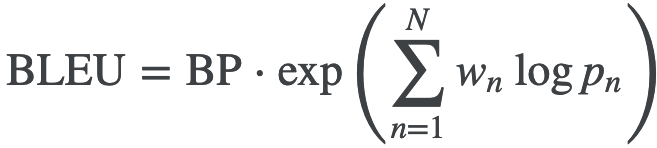

* n specifies the size of the bag of word, or the n-gram
* w_n denotes the weight we will ascribe to the modified precision p_n
* p_n modified precision produced under that n-gram configuration.

### we calculate the weighted average of log precision, exponentiate that sum, and apply some brevity penalty.

# BLEU implementation

In [11]:
def bleu(candidate, referances, weights, n_start, n_end):
    assert n_end >= n_start > 0
    bp = brevity_penalty_implementation(candidate, referances)
    p_n = [modified_precision_implementation(candidate, referances, n) for n in range(n_start, n_end + 1)]
    return bp * np.exp(sum(w * np.log(p) for w, p in zip(weights, p_n)))


# BLEU implementation sanity check

In [12]:
weights = [0.25,0.25,0.25,0.25]
# all the n-grams are given same weightage of 25 %
bleu(candidate_1, references, weights, 1, 4)


0.5045666840058485

# Implementation of BLEU using NLTK 

In [13]:
import nltk.translate.bleu_score as bleu
bleu.sentence_bleu(list(map(lambda references: lower_n_split_values(references), references)), lower_n_split_values(candidate_1))


0.5045666840058485

### Note: You can observe that custom implementation and nltk implementation gave same output.

In [14]:
list(map(lambda references: lower_n_split_values(references), references))

[['it',
  'is',
  'a',
  'guide',
  'to',
  'action',
  'that',
  'ensures',
  'that',
  'the',
  'military',
  'will',
  'forever',
  'heed',
  'party',
  'commands'],
 ['it',
  'is',
  'the',
  'guiding',
  'principle',
  'which',
  'guarantees',
  'the',
  'military',
  'forces',
  'always',
  'being',
  'under',
  'the',
  'command',
  'of',
  'the',
  'party'],
 ['it',
  'is',
  'the',
  'practical',
  'guide',
  'for',
  'the',
  'army',
  'always',
  'to',
  'heed',
  'the',
  'directions',
  'of',
  'the',
  'party']]